In [131]:
import sys

from pyedflib import EdfReader

from config.constants import SAMPLING_FREQUENCY_HZ
from config.intervals import SEGMENT

sys.path.append('..')

import matplotlib
import numpy as np
from numpy import sin, pi, arange
from matplotlib import pyplot as plt
import pandas as pd
import scipy

from config.paths import PATHS, PatientDir

matplotlib.rcParams['figure.figsize'] = (20, 5)

# Signal

(3001,)


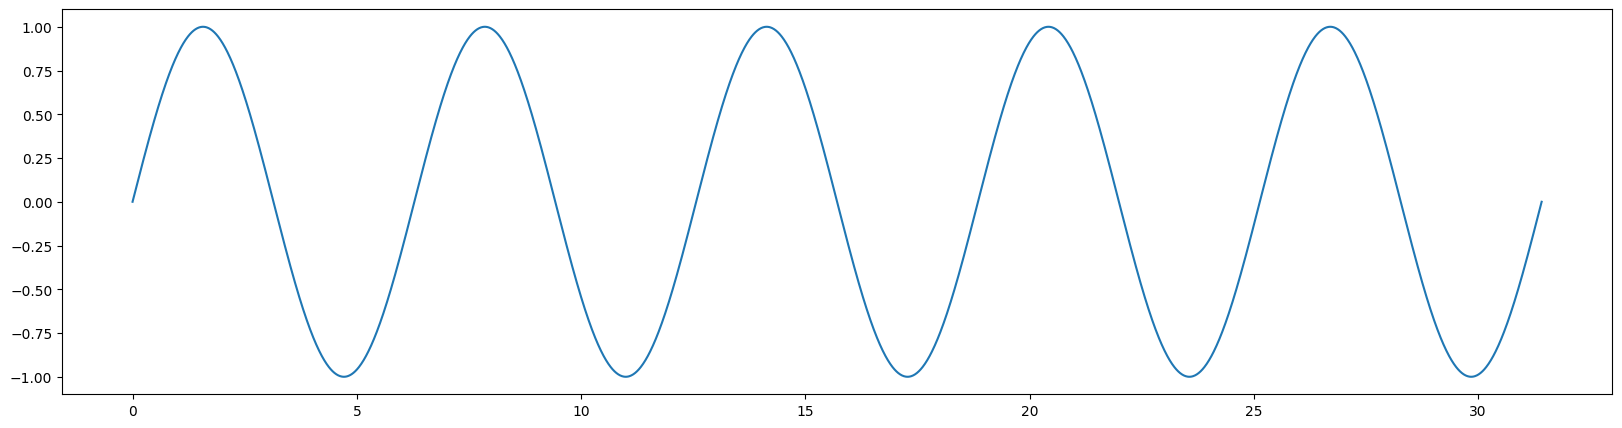

In [132]:
timepoints = arange(0, 10 * pi, pi / 300)
s = sin(timepoints)
print(timepoints.shape)
plt.plot(timepoints, s)

# Real Signal

In [133]:
# pdir = PATHS.patient_dirs()[0]
# edf_path = next(pdir.edf_dir.iterdir())

pdir = PatientDir(PATHS.for_mayo_dir / 'B52K3P3G')
edf_path = pdir.edf_dir / 'B52K3P3G_2021-10-08_11-31-42.edf'
start_idx = 18630

edf_path

PosixPath('/data/home/webb/UNEEG_data/20240201_UNEEG_ForMayo/B52K3P3G/edf_data/B52K3P3G_2021-10-08_11-31-42.edf')

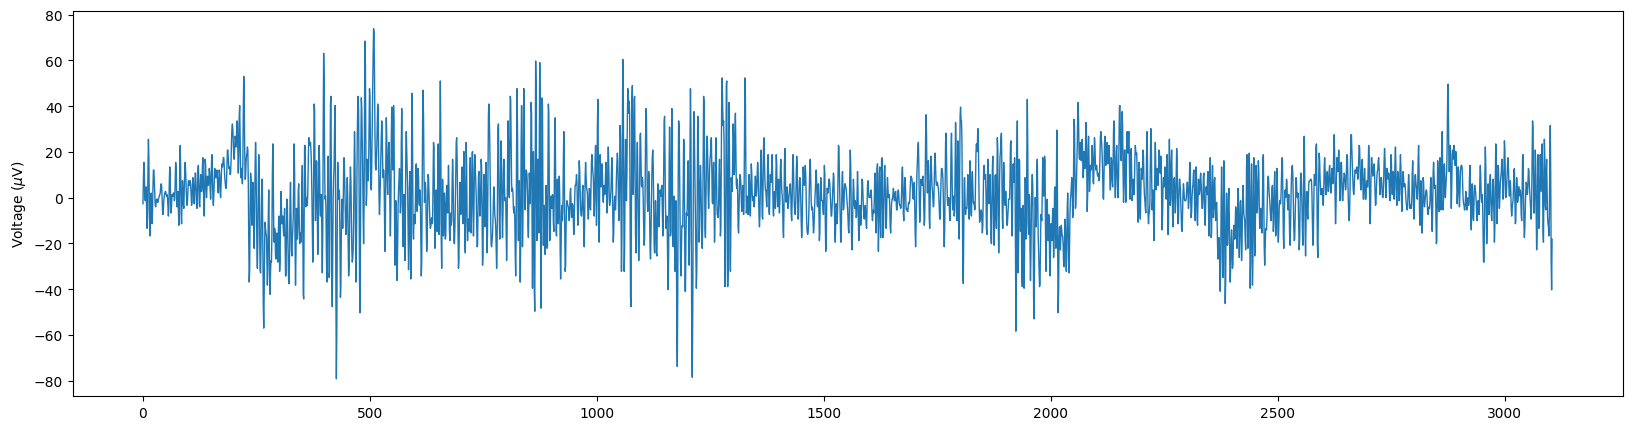

In [134]:
with EdfReader(str(edf_path)) as edf:
    s = edf.readSignal(chn=0, start=start_idx, n=SEGMENT.n_samples)

# t = np.arange(SEGMENT.n_samples) / SAMPLING_FREQUENCY_HZ
# plt.plot(t, s, linewidth=1)
# plt.xlabel('Time (s)')

plt.plot(s, linewidth=1)
plt.ylabel('Voltage ($\mu$V)')
plt.show()

# My Implementation (Pure Python)

In [135]:
def autocorrelation(s: np.ndarray, lag: int):
    if lag == 0:
        return 1

    sd = s - s.mean()  # demean
    summ = (sd[:-lag] * sd[lag:]).sum()
    C_lag = summ / (len(s) * s.var())
    return C_lag

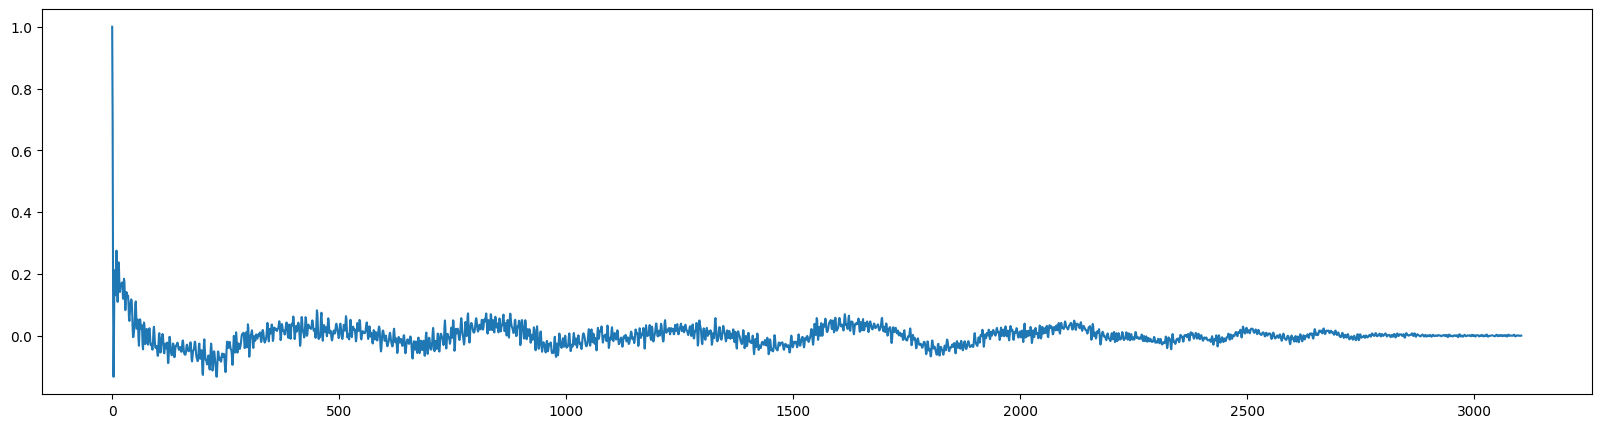

In [136]:
corr_python = []
for lag in range(len(s)):
    corr_python.append(autocorrelation(s, lag))

plt.plot(corr_python)

# Numpy

In [137]:
corr_np_valid = np.correlate(s, s, 'valid')
corr_np_valid_normalized = corr_np_valid / (s.var() * len(s))
print(corr_np_valid_normalized)

[1.01293672]


(6209,)


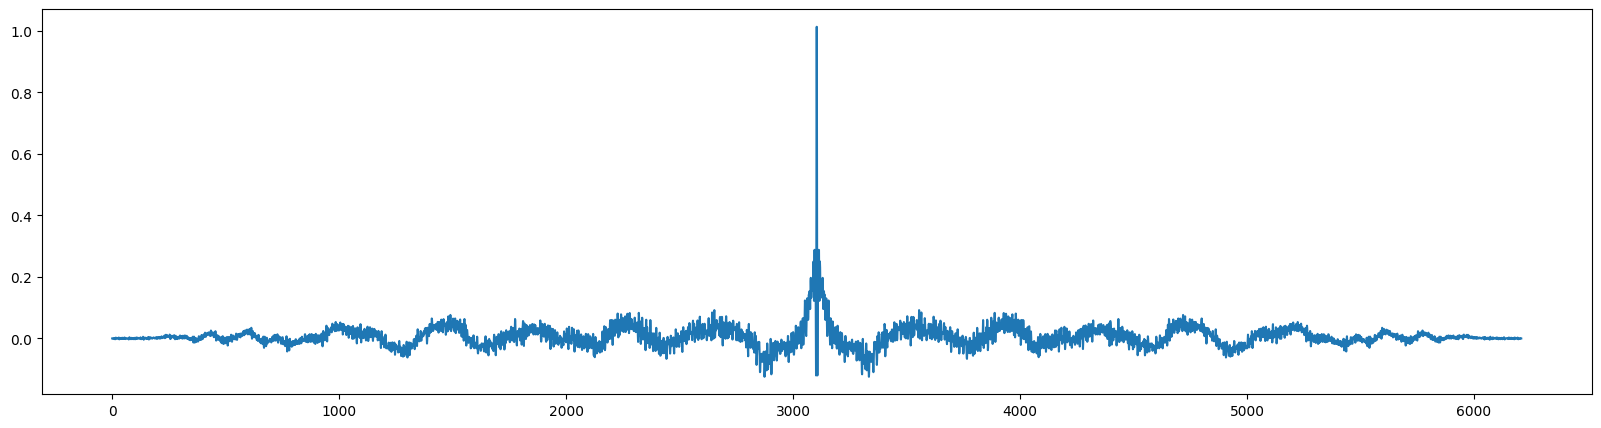

In [138]:
corr_np = np.correlate(s, s, 'full')
print(corr_np.shape)
corr_np_normalized = corr_np / (
            s.var() * len(s))  # this is not necessary if we just want to find the half max (maybe also less robust)
plt.plot(corr_np_normalized)

In [139]:
middle = corr_np.shape[0] / 2
middle

3104.5

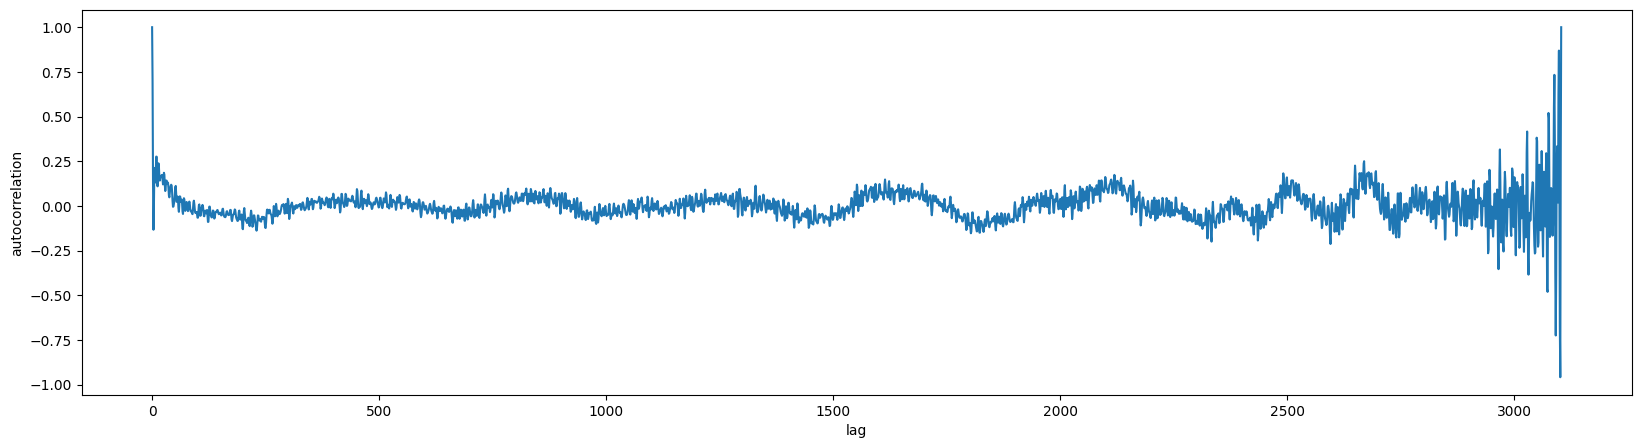

In [140]:
s_ = pd.Series(s)
corr_pandas = []

for lag in range(len(s)):
    corr_pandas.append(s_.autocorr(lag))
plt.plot(corr_pandas)
plt.xlabel('lag')
plt.ylabel('autocorrelation')
plt.show()

# Scipy

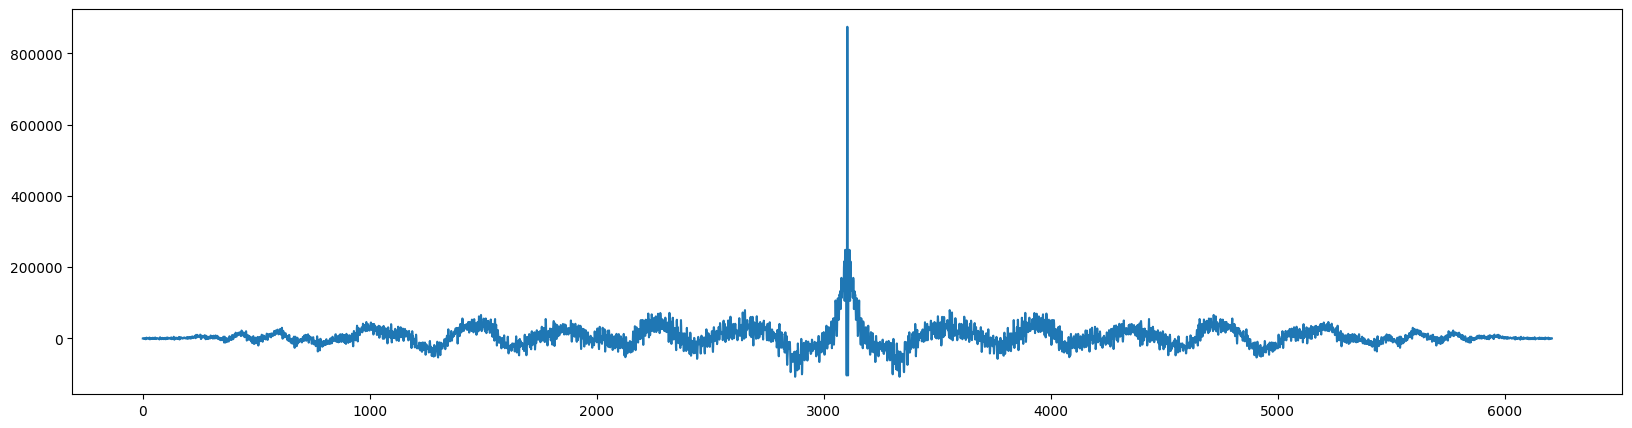

In [141]:
corr_scipy = scipy.signal.correlate(s, s, )
plt.plot(corr_scipy)

In [142]:
np.corrcoef(s[:])

np.float64(1.0)

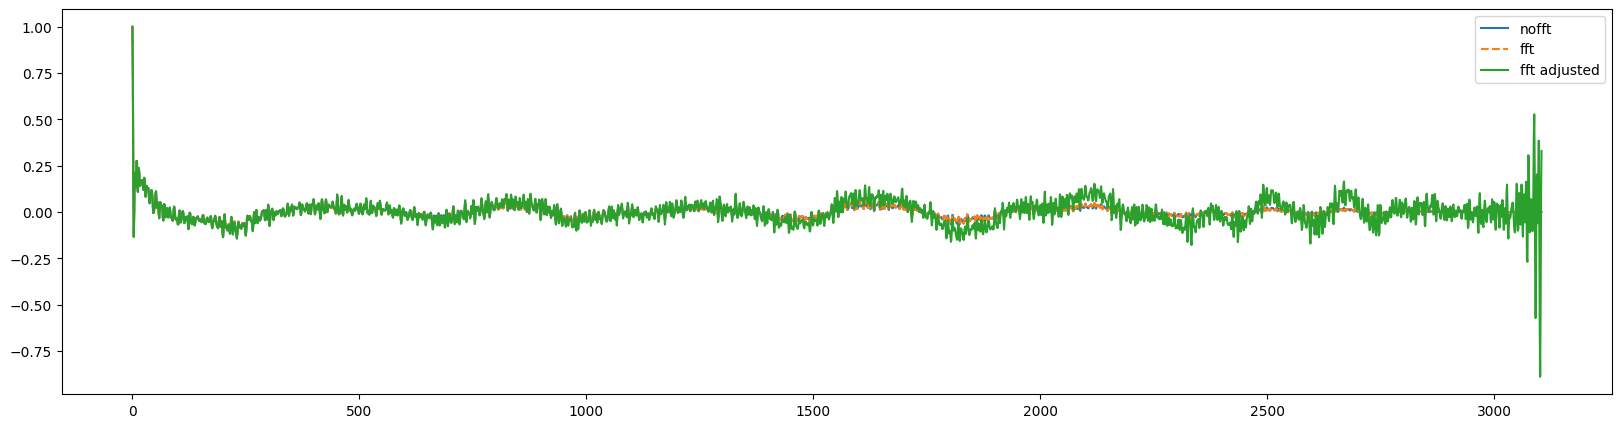

In [152]:
from statsmodels.tsa import stattools

corr_statsmodels_nofft = stattools.acf(s, nlags=len(s), fft=True)
corr_statsmodels_fft = stattools.acf(s, nlags=len(s), fft=True)
corr_statsmodels_fft_adjusted = stattools.acf(s, nlags=len(s), adjusted=True, fft=True)

plt.plot(corr_statsmodels_nofft, label='nofft', )
plt.plot(corr_statsmodels_fft, label='fft', linestyle='--')
plt.plot(corr_statsmodels_fft_adjusted, label='fft adjusted')
plt.legend()
plt.show()

# Speed Comparison
stattools.acf with fft=True is the fast and practical
scipy is faster, but the output doesn't have quite the format I want

In [144]:
import timeit

times = {}
calls = [
    'stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=False)',
    'stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=True)',
    "np.correlate(s, s, 'full')",
    'scipy.signal.correlate(s, s)'
    #'[autocorrelation(s, lag) for lag in range(len(s))]',
]

for call in calls:
    times[call] = timeit.timeit(call, number=10000, globals=globals())
    print(f"{call}: {times[call]}")

stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=False): 16.113971875980496
stattools.acf(s,nlags=s.shape[0], adjusted=True, fft=True): 2.5910947835072875
np.correlate(s, s, 'full'): 11.32472025230527
scipy.signal.correlate(s, s): 2.463979111984372


# Autocorrelation function width (ACFW)

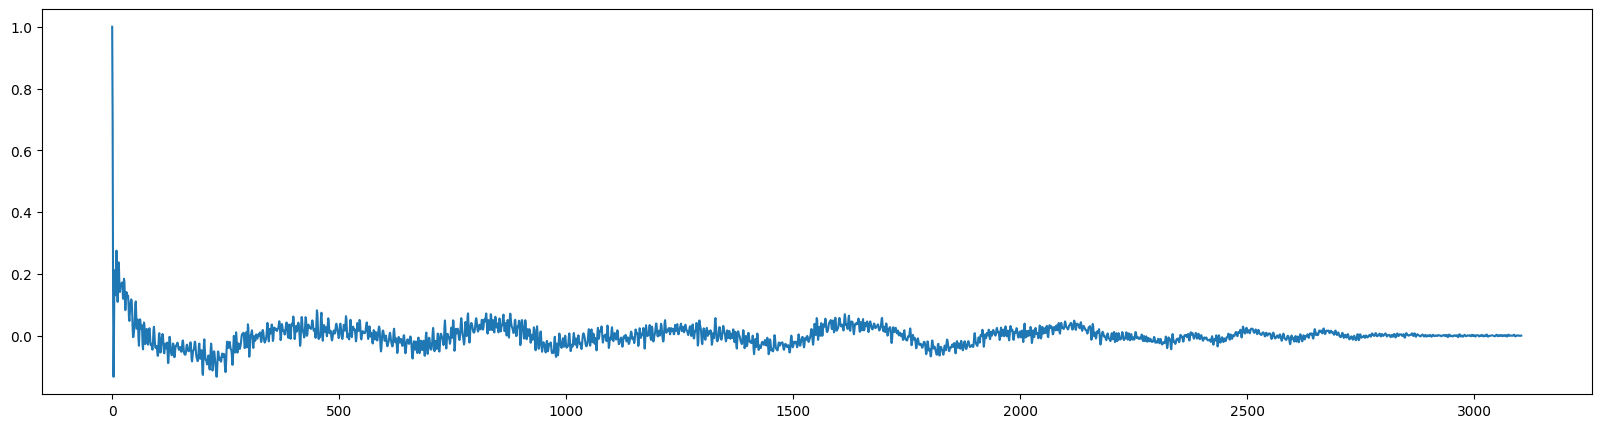

In [145]:
autocorr = stattools.acf(s, nlags=len(s), fft=True)
assert autocorr.max() == 1, "Autocorrelation max isn't 1"
plt.plot(autocorr)
plt.show()

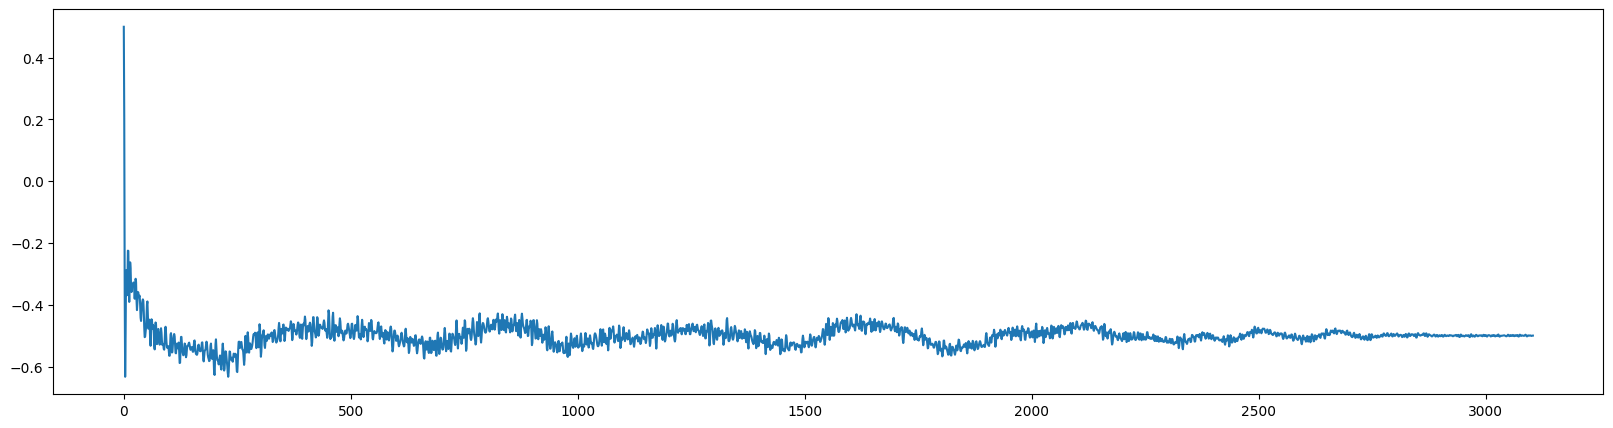

In [146]:
# Find the lag (index) where the ACF is closest to its half-max (=0.5)
autocorr_adj = autocorr - 0.5  # values close to 0.5 are now close to 0
plt.plot(autocorr_adj)
plt.show()

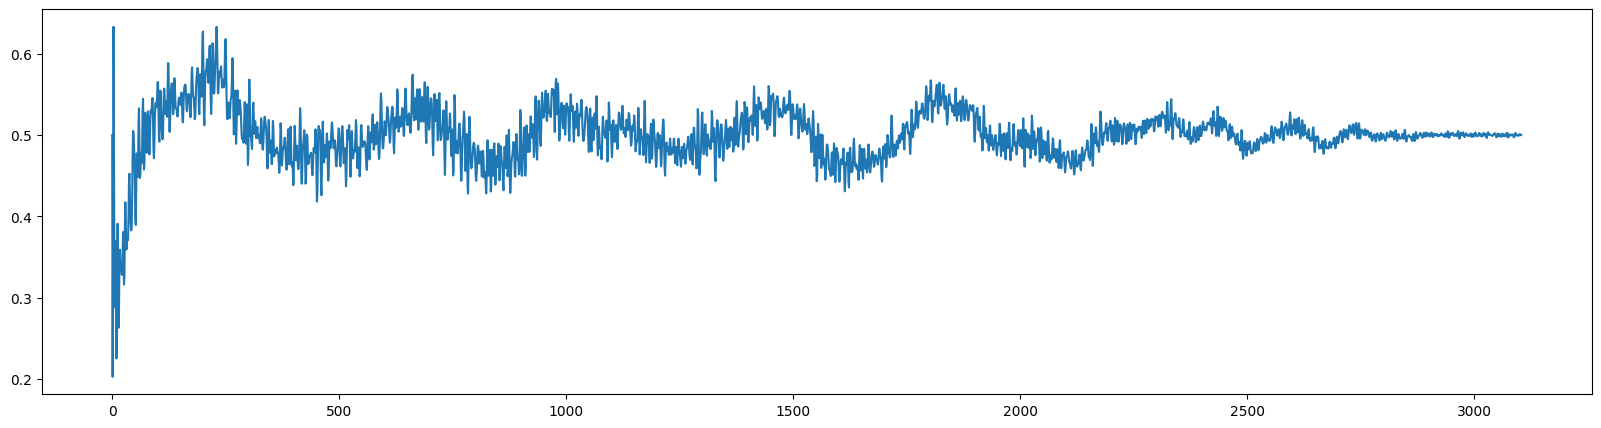

In [147]:
autocorr_adj_abs = np.abs(autocorr_adj)  # Now only values close to 0 are minimal
plt.plot(autocorr_adj_abs)

In [148]:
lag = autocorr_adj_abs.argmin()
print(f"lag: {lag}")
print(autocorr[lag])

lag: 1
0.7024680027136997


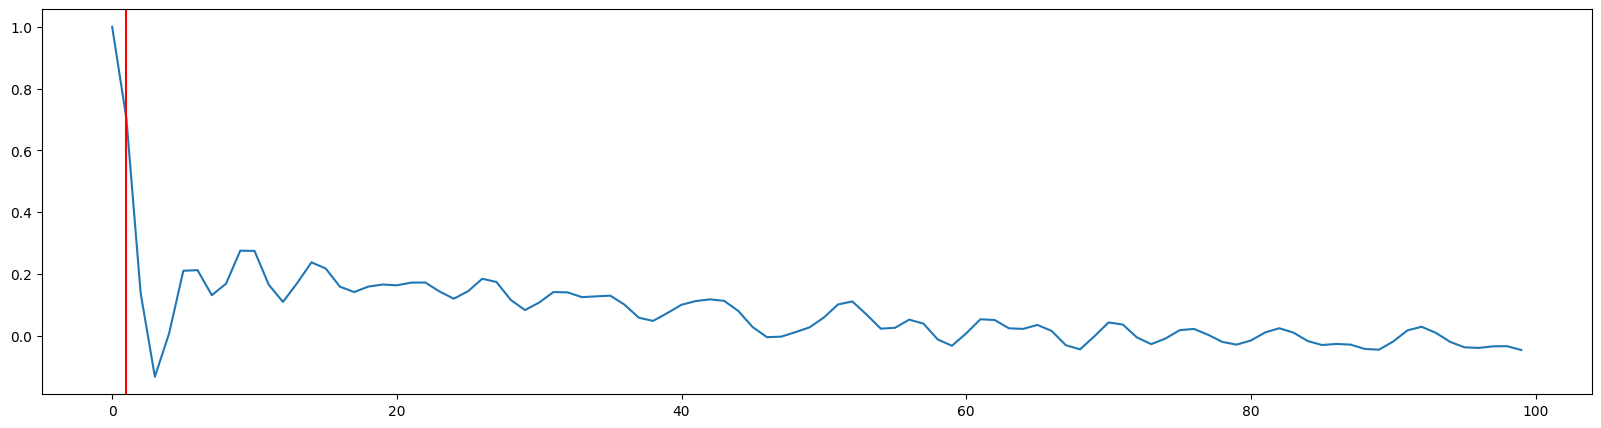

In [159]:
plt.plot(autocorr[:100])
plt.axvline(lag, color='r')

In [150]:
from statsmodels.tsa import stattools


def autocorrelation_function_width(sig: np.ndarray) -> int:
    """Computes the ACFW (autocorrelation function width) for a signal.
    The ACFW is the lag at which the autocorrelation is half its maximum value.
    :param sig: signal to compute ACFW for
    :return: ACFW width (lag)
    """
    # compute autocorrelation for all lags
    autocorr = stattools.acf(sig, nlags=len(sig), fft=True)
    assert autocorr.max() == 1, "Autocorrelation max isn't 1"

    # Find the lag (index) where the ACF is closest to its half-max (=0.5)
    # The half-max is 0.5 because the maximum autocorrelation is 1
    # Subtracting 0.5 makes the values close to 0.5 become close to 0
    # Taking the absolute values makes values close to 0 be the minimal elements
    # Then, the argmin is taken to find the value closest to 0 (the half-max index/lag)
    return np.abs(autocorr - 0.5).argmin()


In [151]:
timeit.timeit('autocorrelation_function_width(s)', number=10000, globals=globals())

3.5154266050085425